# Text classification with TensorFlow Hub: AG News Classification

## About the Data
### Origin
AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity.

The AG's news topic classification dataset is constructed by Xiang Zhang from the dataset above. It is used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).

### Description
The AG's news topic classification dataset is constructed by choosing 4 largest classes from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.

The file classes.txt contains a list of classes corresponding to each label.

The files train.csv and test.csv contain all the training samples as comma-sparated values. There are 3 columns in them, corresponding to class index (1 to 4), title and description. The title and description are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".

This notebook classifies AG news when given the title and the description of the news. This is an example of multi-class classification.
</br>
</br>
This notebook uses `tf.keras`, a high-level API to build and models in Tensorflow, and `tensorflow_hub`, a library for loading trained models from TFHub in a single line of code.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import plot_model

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

tf.random.set_seed(42)

Version:  2.11.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


## Load the dataset

In [2]:
TRAIN_FILE_PATH="/kaggle/input/ag-news-classification-dataset/train.csv"
TEST_FILE_PATH='/kaggle/input/ag-news-classification-dataset/train.csv'

train_data=pd.read_csv(TRAIN_FILE_PATH)
test_data=pd.read_csv(TEST_FILE_PATH)

train_data.columns = ['ClassIndex', 'Title', 'Description']
test_data.columns = ['ClassIndex', 'Title', 'Description']

X_train=train_data['Title']+" "+train_data['Description']
y_train=train_data['ClassIndex'].apply(lambda x:x-1)

X_test=test_data['Title']+ " "+test_data['Description']
y_test=test_data['ClassIndex'].apply(lambda x:x-1)

X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.2,random_state=42)

maxlen=X_train.map(lambda x:len(x.split())).max()
train_data.head()

labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']
raw_train_ds=tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(10000).batch(32)
raw_val_ds=tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(10000).batch(32)
raw_test_ds=tf.data.Dataset.from_tensor_slices((X_test,y_test)).shuffle(10000).batch(32)

## Explore the data
Let's print first 5 examples

In [3]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(5):
    print("Title: ", text_batch.numpy()[i])
    print("Label: ", labels[label_batch.numpy()[i]])

Title:  b'Baltimore to quit stock market Baltimore Technologies, once a darling of the dotcom boom, is to quit the London stock market, putting an end to its chequered history as a listed company.'
Label:  Business News
Title:  b'Suspected Israeli Agents Kill Militant in Syria  DAMASCUS (Reuters) - Syria accused Israel of terrorism  after a bomb -- which Israeli security sources said Israel  planted -- killed a Hamas official in Damascus on Sunday. Hamas  vowed to retaliate.'
Label:  World News
Title:  b'Cardinal shakeup to cut jobs, improve profit Cardinal Health Inc. will cut 4,200 jobs, or 7 percent of its work force, as part of a three-year restructuring plan outlined Monday by the Central Ohio health-care products and services provider.'
Label:  Business News
Title:  b"Internet leaders ponder U.S. tech policies Silicon Valley luminaries worry about government's stance on stock options, outsourcing, research and education."
Label:  Science-Technology News
Title:  b'Fossil Egg Finds

## Build the model
The neural network is created by stacking layers - this requires three main architectural decisions:
- How to represent the text?
- How many layers to use in the model?
- How many hidden units to use for each layer?
In this notebook, the input data consists of sentences. The labels to predict are the title label
</br>
</br>
One way to represent the text is to convert sentences into embedding vectors. Use a pre-trained text embedding as the first layer, which will have three advantages.
- You don't have to worry about text preprocessing
- Benefit from transfer learning
- the embedding has a fixed size, so it's simpler to process.
For this notebook, we use a **pre-trained text embedding model** from Tensorflow Hub called google/nnlm-en-dim128/2
</br>
</br>
There are many other pre-trained text embeddings from TFHub that can be used

- google/nnlm-en-dim128/2 - trained with the same NNLM architecture on the same data as google/nnlm-en-dim50/2, but with a larger embedding dimension. Larger dimensional embeddings can improve on your task but it may take longer to train your model.
- google/nnlm-en-dim128-with-normalization/2 - the same as google/nnlm-en-dim128/2, but with additional text normalization such as removing punctuation. This can help if the text in your task contains additional characters or punctuation.
- google/universal-sentence-encoder/4 - a much larger model yielding 512 dimensional embeddings trained with a deep averaging network (DAN) encoder.

In [4]:
embedding="https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
# embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer=hub.KerasLayer(embedding,input_shape=[],dtype=tf.string,trainable=True)
hub_layer(text_batch)

<tf.Tensor: shape=(32, 128), dtype=float32, numpy=
array([[ 5.46282828e-01,  5.86778484e-02,  1.44842237e-01, ...,
         5.07801138e-02,  1.11548334e-01, -1.12294909e-02],
       [ 3.07095617e-01,  3.10983900e-02, -2.03976750e-01, ...,
         1.11942291e-02,  5.88032305e-02,  1.50789037e-01],
       [ 5.58731437e-01,  2.16595024e-01,  1.18216202e-01, ...,
         1.68668419e-01,  1.18011601e-01,  3.27914546e-04],
       ...,
       [ 8.38478386e-01,  1.41556308e-01, -1.34739012e-01, ...,
        -1.35254681e-01,  6.65760040e-02, -1.58221927e-02],
       [ 6.22690618e-01,  4.88047535e-03, -1.74307525e-01, ...,
         9.54426751e-02, -3.68175842e-02, -8.58027190e-02],
       [ 5.17615736e-01,  9.12861452e-02, -7.72206858e-02, ...,
         8.19960088e-02, -5.42062782e-02,  1.56493187e-01]], dtype=float32)>

Let's now build the full model

In [5]:
model=tf.keras.Sequential([
   hub_layer,
   tf.keras.layers.Reshape((1, 128)),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
   tf.keras.layers.GlobalMaxPooling1D(),
   tf.keras.layers.Dense(1024),
   tf.keras.layers.Dropout(0.25),
   tf.keras.layers.Dense(512),
   tf.keras.layers.Dropout(0.25),
   tf.keras.layers.Dense(256),
   tf.keras.layers.Dropout(0.25),
   tf.keras.layers.Dense(128),
   tf.keras.layers.Dropout(0.25),
   tf.keras.layers.Dense(64),
   tf.keras.layers.Dropout(0.25),
   tf.keras.layers.Dense(4)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 1, 128)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 256)           263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 128)           164352    
 nal)                                                            
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                        

The layers are stacked sequentially to build the classifier:
1. The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentences into its embedding vector. The pre-trained text embedding model that we are using splits the sentence into tokens, embeds eack token and then combines the embedding, The resulting dimension are: `(num_examples,embedding_dimensio)`. For this NNLM model, the embedding dimension is 128
1. This fixed-length output vector is reshape through the `Reshape()` layer to feed to the next `bidirectional()` layes.
1. The last layer is densely connected with a 4 single output node since this is the multi-class classification problem.

## Configure the dataset for performance
These are two important methods we should use when loading data to make sure that I/O does not become blocking
</br>
</br>
`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training our model. If dataset is too large fit into memory, we can also use this method to create a performance on-disk cache, which is more efficient to read than many small filed.
</br>
</br>
`.prefetch()` overlaps data preprocessing and model execution while training


In [6]:
AUTOTUNE=tf.data.AUTOTUNE

train_ds=raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds=raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds=raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Loss function and optimizer
A model needs a loss function and an optimizer for training, Since this is a multi-class classification problem and the model outputs a probability of four nodes, we'll use `losses.SparseCategoricalCrossentropy()` loss function.

In [7]:
callbacks=[
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=4,
        verbose=1,
    ),
    ModelCheckpoint(
        filepath='weight.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

## Train the model
We will train the model by passing the `dataset` object to the fit method

In [8]:
history=model.fit(train_ds,validation_data=val_ds,epochs=20,callbacks=callbacks)

Epoch 1/20
2999/3000 [============================>.] - ETA: 0s - loss: 0.3163 - accuracy: 0.9010
Epoch 1: val_accuracy improved from -inf to 0.91767, saving model to weight.h5
3000/3000 [==============================] - 185s 58ms/step - loss: 0.3162 - accuracy: 0.9010 - val_loss: 0.2461 - val_accuracy: 0.9177
Epoch 2/20
2999/3000 [============================>.] - ETA: 0s - loss: 0.1560 - accuracy: 0.9480
Epoch 2: val_accuracy did not improve from 0.91767
3000/3000 [==============================] - 133s 44ms/step - loss: 0.1560 - accuracy: 0.9480 - val_loss: 0.3683 - val_accuracy: 0.8936
Epoch 3/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0842 - accuracy: 0.9729
Epoch 3: val_accuracy did not improve from 0.91767
3000/3000 [==============================] - 133s 44ms/step - loss: 0.0842 - accuracy: 0.9729 - val_loss: 0.6623 - val_accuracy: 0.9039
Epoch 4/20
3000/3000 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9839
Epoch 4: val_accura

## Evaluate the model
Let's see how the model performs. Two values will be returned. Loss(a number which represents our error, lower values are better), and accuracy.

In [9]:
results=model.evaluate(test_ds,verbose=2)
for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

3750/3750 - 35s - loss: 0.3460 - accuracy: 0.9501 - 35s/epoch - 9ms/step
loss: 0.346
accuracy: 0.950


# Create a plot of accuracy and loss over time
`model.fit()` returns a `History` object that contains a dictionary with everything happened during training:

In [10]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

These are four entries: one for ach monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

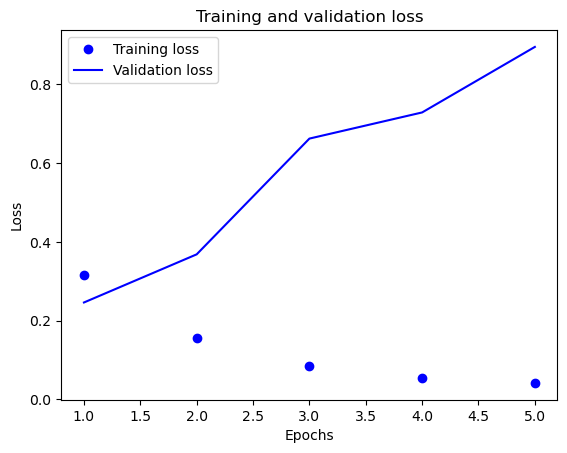

In [11]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

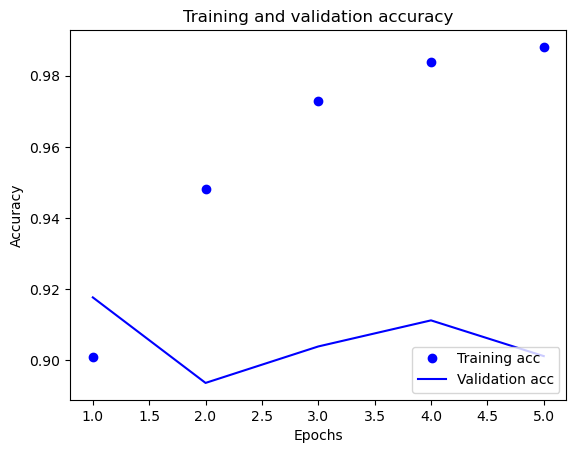

In [12]:
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()